<a href="https://colab.research.google.com/github/shabanakausar/shabanakausar/blob/main/image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparation

In [36]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)


2.13.0


#Read and prepare dataset

In [37]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 20000  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)


#Filter and Preprocess
Here we preprocess the dataset. The function below:

resize image to (IMG_HEIGHT, IMG_WIDTH) shape
rescale pixel values from [0, 255] to [0, 1]

return image(image_tensor) and captions(captions) dictionary.
Note: This dataset is too large to store in an local environment. Therefore, It is stored in a public GCS bucket located in us-central1. So if you access it from a Notebook outside the US, it will be (a) slow and (b) subject to a network charge.

In [38]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000


def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

#Visualize
Let's take a look at images and sample captions in the dataset.



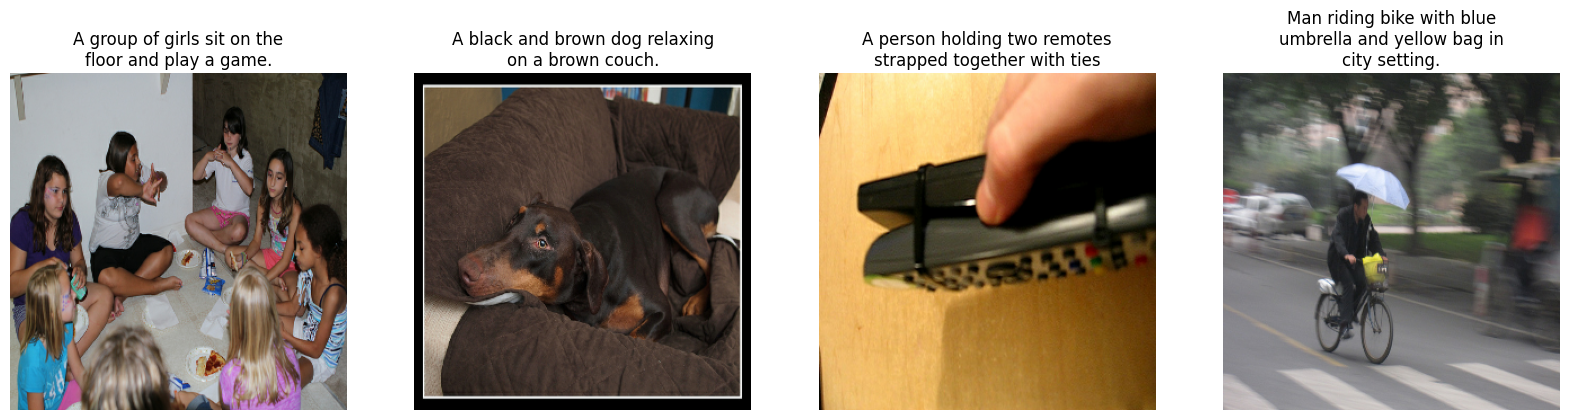

In [39]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")


#Text Preprocessing
We add special tokens to represent the starts (<start>) and the ends (<end>) of sentences.
Start and end tokens are added here because we are using an encoder-decoder model and during prediction, to get the captioning started we use <start> and since captions are of variable length, we terminate the prediction when we see the <end> token.

Then create a full list of the captions for further preprocessing.



In [40]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


trainds = trainds.map(add_start_end_token)



#Preprocess and tokenize the captions
You will transform the text captions into integer sequences using the TextVectorization layer, with the following steps:

* Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top VOCAB_SIZE words.


* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to the length MAX_CAPTION_LEN.


 Here we directly specify 64 number which is sufficient for this dataset, but please note that this value should be computed by processing the entire dataset if you don't want to cut down very long sentense in a dataset.

* Note: This process takes around 5 minutes.

In [41]:
MAX_CAPTION_LEN = 64
# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))


Let's try to tokenize a sample text


In [42]:
tokenizer(["<start> This is a sentence <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 165,  11,   2,   1,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [43]:
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy())

In [44]:
sample_captions

[b'<start> People are flying their kites in the sky. <end>',
 b'<start> A tall giraffe standing in a cage at a zoo. <end>',
 b'<start> Two people standing by a giraffe, and one is feeding it. <end>',
 b'<start> A guy is sitting on a teal bench during the day.  <end>',
 b'<start> People sitting around the conference table looking at written materials. <end>']

In [45]:
print(tokenizer(sample_captions))


tf.Tensor(
[[   3   20   24   74  130  259    8    7  131    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2  152  105   15    8    2  795   21    2  404    4    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3   17   20   15   57    2  105   10  128   11  604   35    4    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

Please note that all the sentenses starts and ends with the same token (e.g. '3' and '4'). These values represent start tokens and end tokens respectively.

You can also convert ids to original text.



In [46]:
for wordid in tokenizer([sample_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")


<start> people are flying their kites in the sky <end>                                                       

Also, we can create Word <-> Index converters using StringLookup layer.


In [47]:

# Lookup table: Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

#Create a tf.data dataset for training
Now Let's apply the adapted tokenization to all the examples and create tf.data Dataset for training.

Here note that we are also creating labels by shifting texts from feature captions.
If we have an input caption "<start> I love cats <end>", its label should be "I love cats <end> <padding>".
With that, our model can try to learn to predict I from <start>.

The dataset should return tuples, where the first elements are features (image_tensor and caption) and the second elements are labels (target).

In [48]:
BATCH_SIZE = 32


def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return (img_tensor, caption), target


batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [49]:
for (img, caption), label in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])


Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3  79  11   2  12  28  11   6   7  81 326   4   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
tf.Tensor(
[ 79  11   2  12  28  11   6   7  81 326   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2  25 142   9 210   5 277   5 269   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  

#Model
Now let's design an image captioning model.
It consists of an image encoder, followed by a caption decoder.

Image Encoder
The image encoder model is very simple. It extracts features through a pre-trained model and passes them to a fully connected layer.

In this example, we extract the features from convolutional layers of InceptionResNetV2 which gives us a vector of (Batch Size, 8, 8, 1536).
We reshape the vector to (Batch Size, 64, 1536)
We squash it to a length of ATTENTION_DIM with a Dense Layer and return (Batch Size, 64, ATTENTION_DIM)
Later, the Attention layer attends over the image to predict the next word.

In [50]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)


In [51]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 reshape_1 (Reshape)         (None, 64, 1536)          0         
                                                                 
 dense_2 (Dense)             (None, 64, 512)           786944    
                                                                 
Total params: 55123680 (210.28 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


#Caption Decoder
The caption decoder incorporates an attention mechanism that focuses on different parts of the input image.

#The attention head
The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example.

Let's look at how this works:

attention equation 1attention equation 2
Where:
Let's look at how this works:


##Calculates the attention weights,
, as a softmax across the encoder's output sequence.
Calculates the context vector as the weighted sum of the encoder outputs.
Last is the
 function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

## attention equation 4
This notebook implement Luong-style attention using pre-defined layers.Attention.

## Decoder Steps
The decoder's job is to generate predictions for the next output token.

The decoder receives current word tokens as a batch.
It embeds the word tokens to ATTENTION_DIM dimension.
GRU layer keeps track of the word embeddings, and returns GRU outputs and states.
Bahdanau-style attention attends over the encoder's output feature by using GRU outputs as a query.
The attention outputs and GRU outputs are added (skip connection), and normalized in a layer normalization layer.
It generates logit predictions for the next token based on the GRU output.
We can define all the steps in Keras Functional API, but please note that here we instantiate layers that have trainable parameters so that we reuse the layers and the weights in inference phase.



In [52]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_atention = Attention()
context_vector = decoder_atention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)


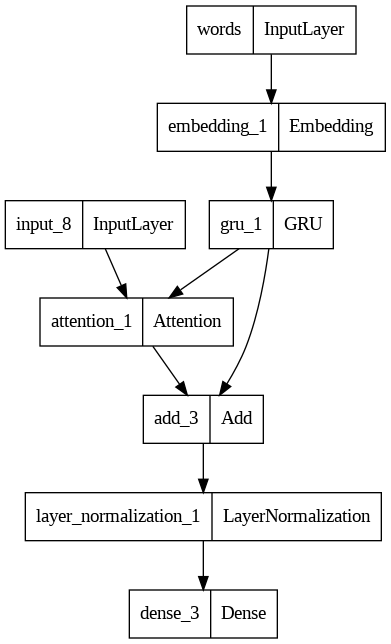

In [53]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)


In [54]:
decoder.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 512)              1024000   ['words[0][0]']               
                                                          0                                       
                                                                                                  
 gru_1 (GRU)                 [(None, 64, 512),            1575936   ['embedding_1[1][0]']         
                              (None, 512)]                                                        
                                                                                            

# Training Model
Now we defined the encoder and the decoder. Let's combine them into an image model for training.

It has two inputs (image_input and word_input, and an output
(decoder_output).
This definition should correspond to the definition of the dataset pipeline.

In [55]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

# Loss Function
The loss function is a simple cross-entropy, but we need to remove padding (0) when calculating it.

So here we extract the length of the sentence (non-0 part), and compute the average of the loss only over the valid sentence part.



In [56]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)


In [57]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

# Training loop
Now we can train the model using the standard model.fit API.
It takes around 15-20 minutes with NVIDIA T4 GPU to train 1 epoch.



In [58]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=1)


2586/2586 [==============================] - 1003s 380ms/step - loss: 0.5720
CPU times: user 13min 25s, sys: 1min 14s, total: 14min 39s
Wall time: 17min 34s


#Caption!
The predict step is different from the training, since we need to keep track of the GRU state during the caption generation, and pass a predicted word to the decoder as an input at the next time step.

In order to do so, let's define another model for prediction while using the trained weights, so that it can keep and update the GRU state during the caption generation.



In [59]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_atention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)

* Initialize the GRU states as zero vectors.
* Preprocess an input image, pass it to the encoder, and extract image features.
* Setup word tokens of <start> to start captioning.

* In the for loop, we
* pass word tokens (dec_input), GRU states (gru_state) and image features (features) to the prediction decoder and get predictions (predictions), and the updated GRU states.

* select Top-K words from logits, and choose a word probabilistically so that we avoid computing softmax over VOCAB_SIZE-sized vector.

* stop predicting when the model predicts the <end> token.
replace the input word token with the predicted word token for the next step.


In [60]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

Let's caption!



an open smart phone with some notes on it.
a couple of different types of monitors on a table.
a picture of a person wearing skis with a cup of water.
the man holding up his lap tops while using a smart phone.
there is a man on the table and holding an electronic equipment.


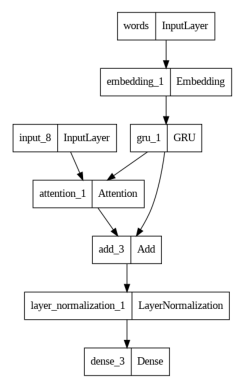

In [73]:
filename = "model.png"  # you can also try surf.jpeg

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");


In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# How does it look?
It seems the model captures the key aspects of the image: people, baseball, and a ball, although it could not be grammatically perfect.

#Optional Task:
Upload your own image and generate captions with it.
Also, you can try to train longer to achieve better captions.

#Summary
We learned how to build an image captioning model by creating an image encoder and a text decoder.

